In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-13 00:17:41.287394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:17:41.291023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:17:41.291121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:17:41.291662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

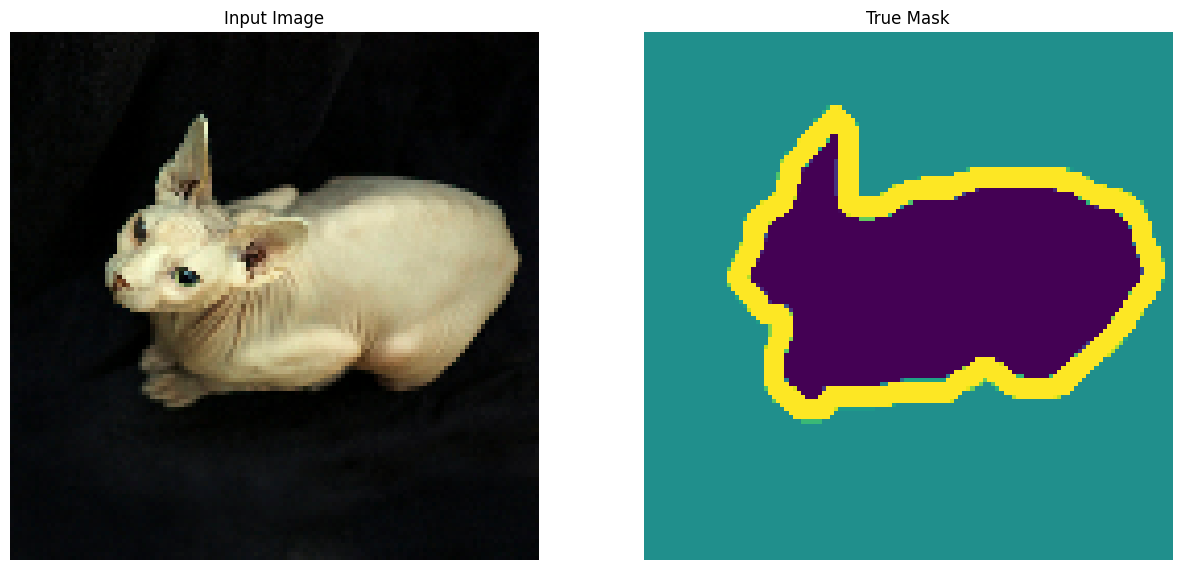

In [6]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [7]:
model = tf.keras.Sequential()    

# block 1
model.add(tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.BatchNormalization())

# block 2
model.add(tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

# block 3
model.add(tf.keras.layers.Conv2D(64, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

# block 4
model.add(tf.keras.layers.Conv2D(64, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

# block 5
model.add(tf.keras.layers.Conv2D(64, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

# output
model.add(tf.keras.layers.Conv2D(3, 3, padding='same'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      15616     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      331840    
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      102464    
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 64)     2

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-13 00:18:27.960518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-13 00:18:28.419334: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 00:18:28.419705: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 00:18:28.419716: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-13 00:18:28.420062: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-13 00:18:28.420094: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

460/460 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.6241

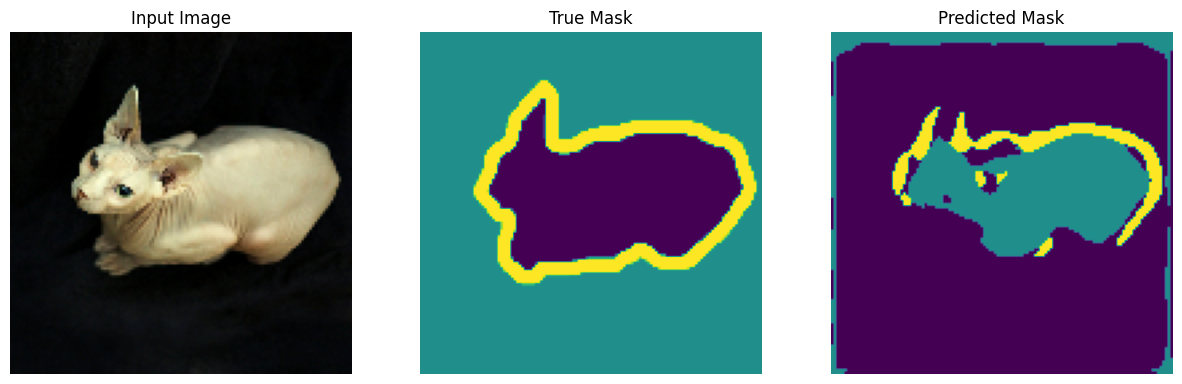


Sample Prediction after epoch 1

460/460 [==============================] - 23s 45ms/step - loss: 0.8096 - accuracy: 0.6241 - val_loss: 1.1089 - val_accuracy: 0.5798
Epoch 2/20
460/460 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.6740

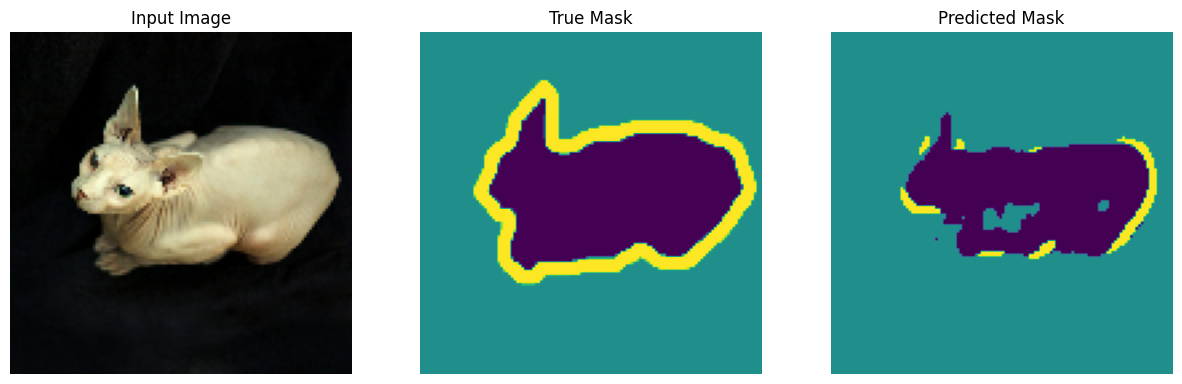


Sample Prediction after epoch 2

460/460 [==============================] - 20s 43ms/step - loss: 0.7164 - accuracy: 0.6740 - val_loss: 0.8170 - val_accuracy: 0.6399
Epoch 3/20
460/460 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.6954

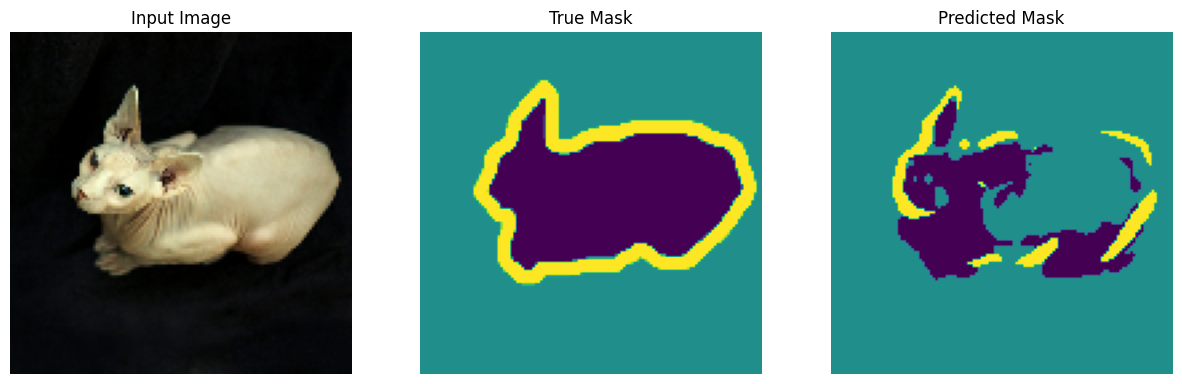


Sample Prediction after epoch 3

460/460 [==============================] - 20s 44ms/step - loss: 0.6819 - accuracy: 0.6954 - val_loss: 0.7532 - val_accuracy: 0.6548
Epoch 4/20
460/460 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7095

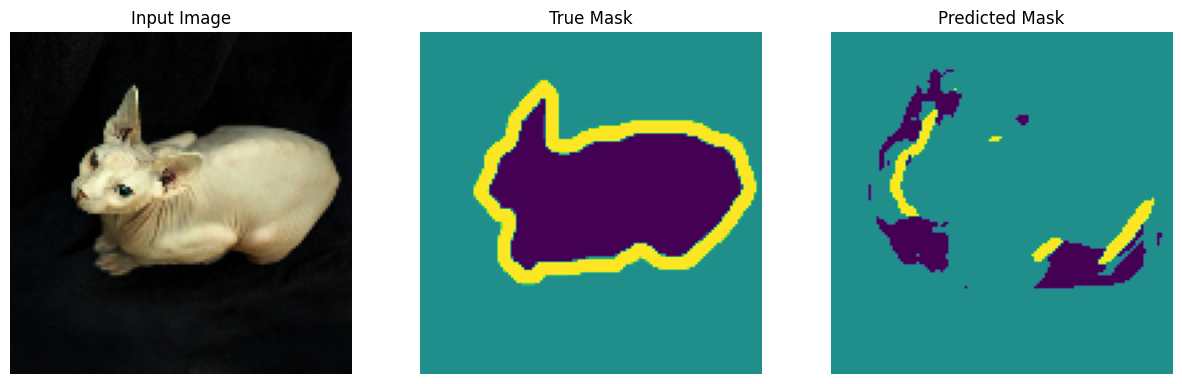


Sample Prediction after epoch 4

460/460 [==============================] - 20s 44ms/step - loss: 0.6575 - accuracy: 0.7095 - val_loss: 0.8513 - val_accuracy: 0.6550
Epoch 5/20
460/460 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.7185

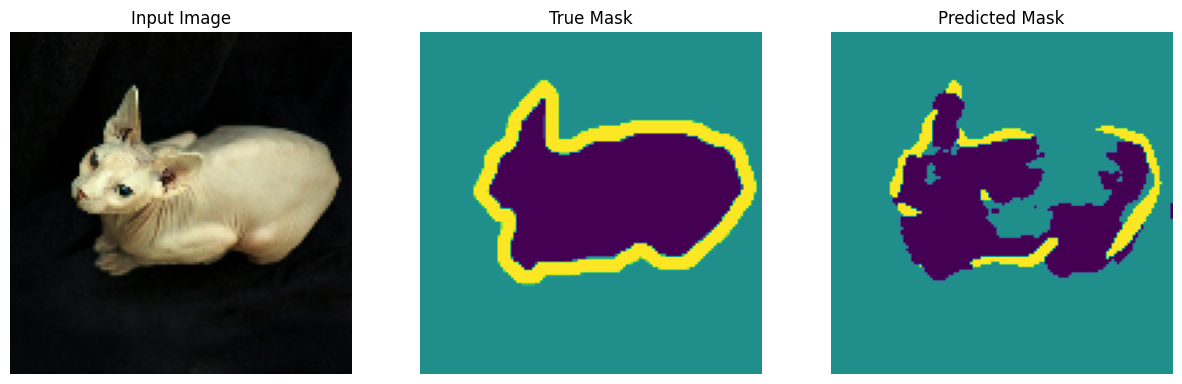


Sample Prediction after epoch 5

460/460 [==============================] - 20s 43ms/step - loss: 0.6426 - accuracy: 0.7185 - val_loss: 0.6600 - val_accuracy: 0.7154
Epoch 6/20
460/460 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.7241

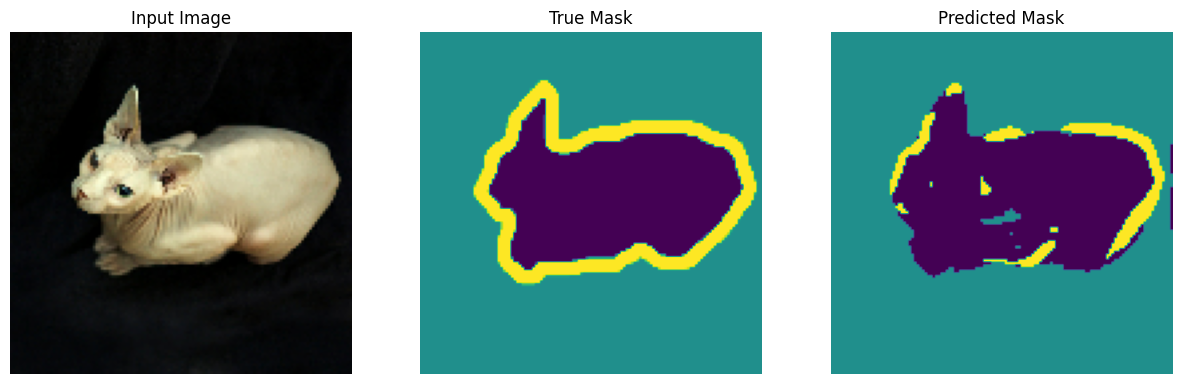


Sample Prediction after epoch 6

460/460 [==============================] - 20s 43ms/step - loss: 0.6312 - accuracy: 0.7241 - val_loss: 0.7601 - val_accuracy: 0.6694
Epoch 7/20
459/460 [============================>.] - ETA: 0s - loss: 0.6143 - accuracy: 0.7328

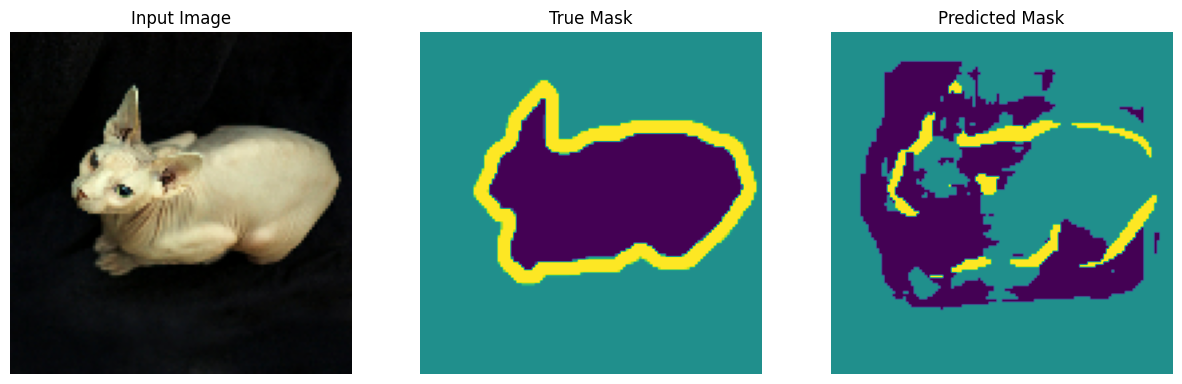


Sample Prediction after epoch 7

460/460 [==============================] - 20s 43ms/step - loss: 0.6145 - accuracy: 0.7327 - val_loss: 0.6792 - val_accuracy: 0.7112
Epoch 8/20
459/460 [============================>.] - ETA: 0s - loss: 0.6033 - accuracy: 0.7395

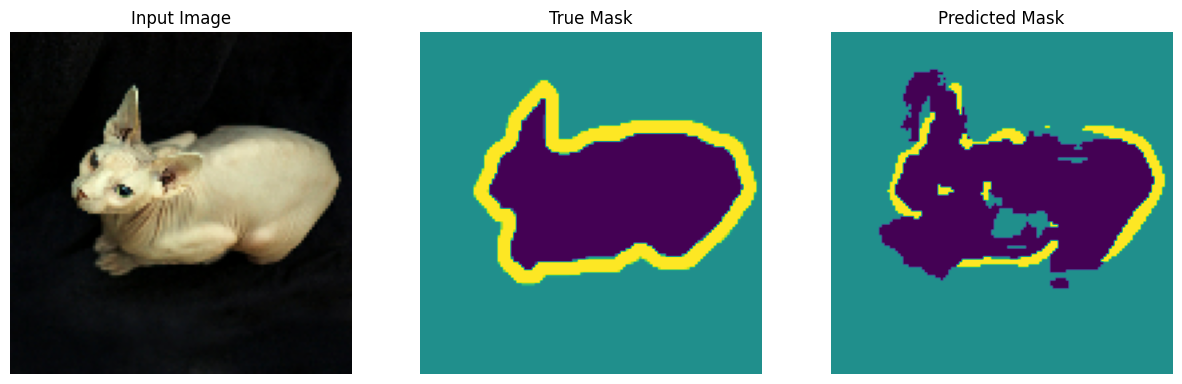


Sample Prediction after epoch 8

460/460 [==============================] - 20s 44ms/step - loss: 0.6031 - accuracy: 0.7396 - val_loss: 0.6640 - val_accuracy: 0.7079
Epoch 9/20
459/460 [============================>.] - ETA: 0s - loss: 0.5929 - accuracy: 0.7446

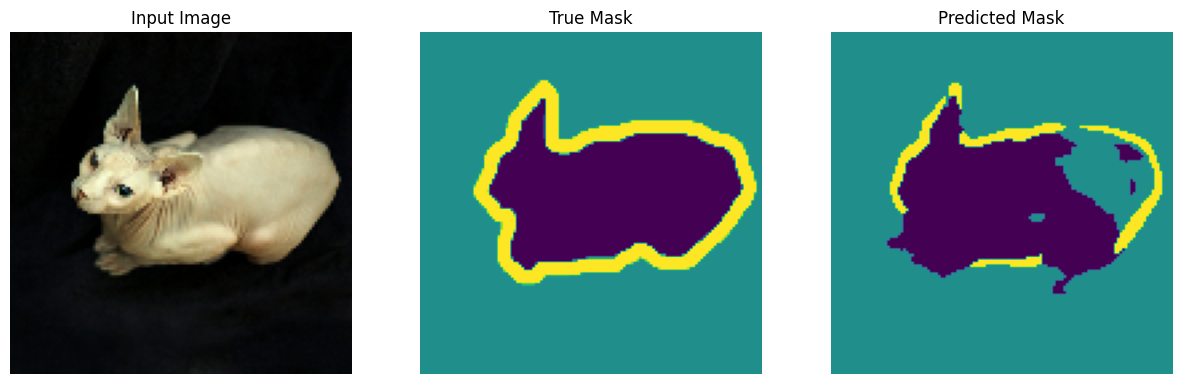


Sample Prediction after epoch 9

460/460 [==============================] - 20s 43ms/step - loss: 0.5928 - accuracy: 0.7446 - val_loss: 0.6270 - val_accuracy: 0.7331
Epoch 10/20
460/460 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.7504

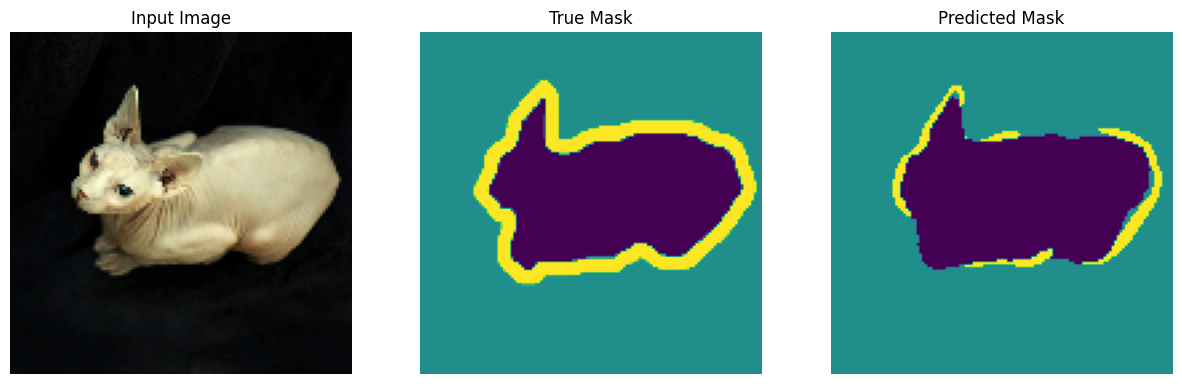


Sample Prediction after epoch 10

460/460 [==============================] - 20s 44ms/step - loss: 0.5811 - accuracy: 0.7504 - val_loss: 0.6535 - val_accuracy: 0.7259
Epoch 11/20
460/460 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7542

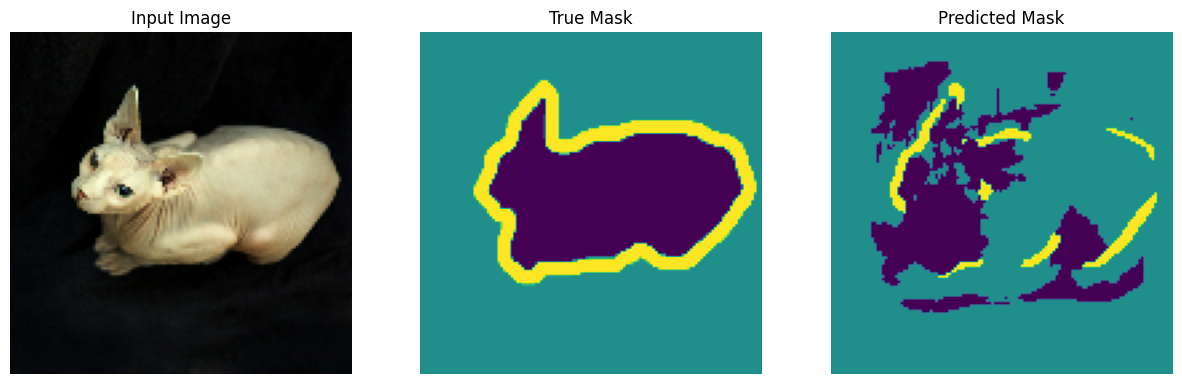


Sample Prediction after epoch 11

460/460 [==============================] - 20s 43ms/step - loss: 0.5728 - accuracy: 0.7542 - val_loss: 0.6143 - val_accuracy: 0.7327
Epoch 12/20
460/460 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.7593

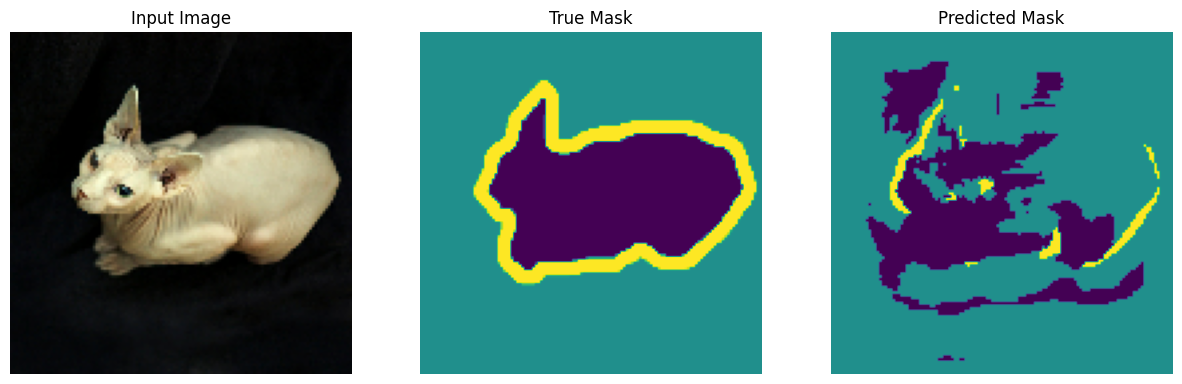


Sample Prediction after epoch 12

460/460 [==============================] - 20s 43ms/step - loss: 0.5626 - accuracy: 0.7593 - val_loss: 0.5729 - val_accuracy: 0.7514
Epoch 13/20
460/460 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.7635

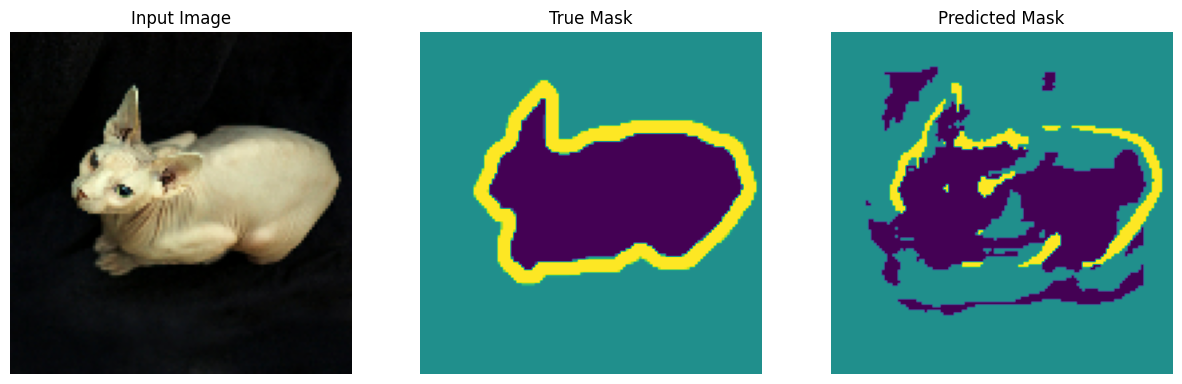


Sample Prediction after epoch 13

460/460 [==============================] - 20s 44ms/step - loss: 0.5550 - accuracy: 0.7635 - val_loss: 0.5799 - val_accuracy: 0.7516
Epoch 14/20
459/460 [============================>.] - ETA: 0s - loss: 0.5492 - accuracy: 0.7653

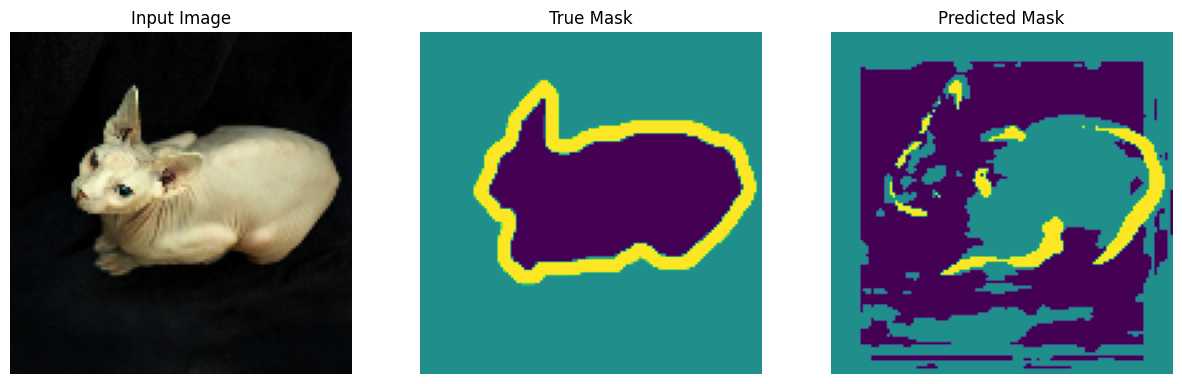


Sample Prediction after epoch 14

460/460 [==============================] - 20s 44ms/step - loss: 0.5496 - accuracy: 0.7652 - val_loss: 0.6747 - val_accuracy: 0.7028
Epoch 15/20
460/460 [==============================] - ETA: 0s - loss: 0.5446 - accuracy: 0.7679

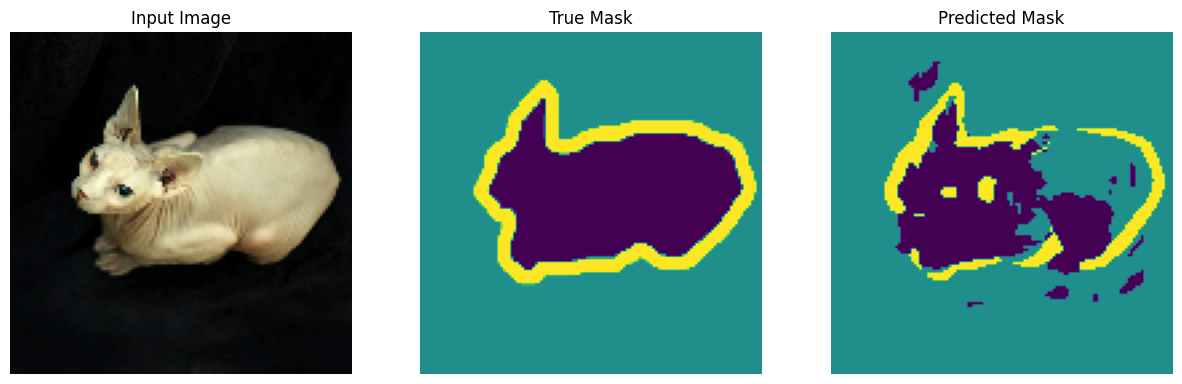


Sample Prediction after epoch 15

460/460 [==============================] - 20s 44ms/step - loss: 0.5446 - accuracy: 0.7679 - val_loss: 0.5542 - val_accuracy: 0.7673
Epoch 16/20
460/460 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7705

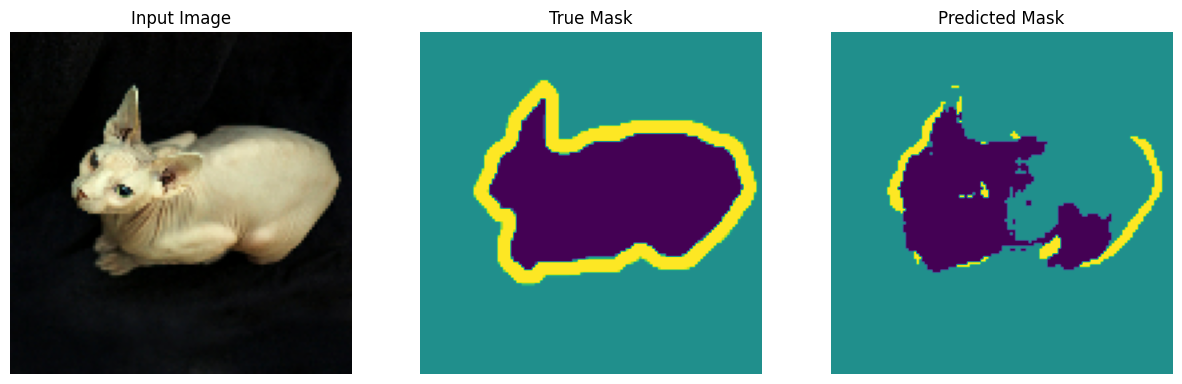


Sample Prediction after epoch 16

460/460 [==============================] - 20s 44ms/step - loss: 0.5386 - accuracy: 0.7705 - val_loss: 0.5893 - val_accuracy: 0.7447
Epoch 17/20
460/460 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7745

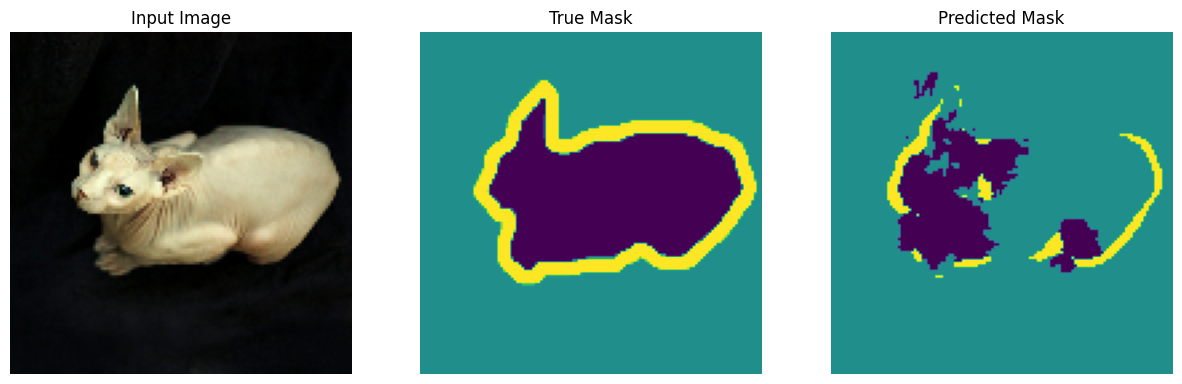


Sample Prediction after epoch 17

460/460 [==============================] - 20s 44ms/step - loss: 0.5310 - accuracy: 0.7745 - val_loss: 0.5963 - val_accuracy: 0.7485
Epoch 18/20
460/460 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7741

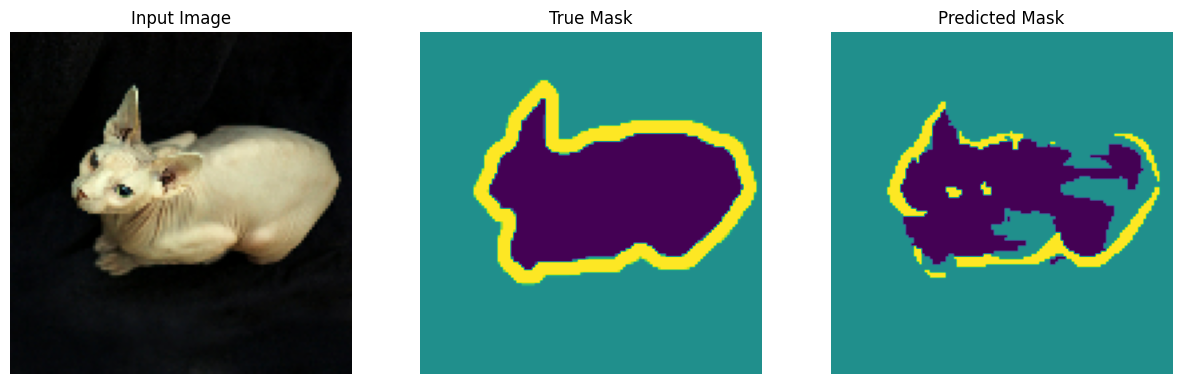


Sample Prediction after epoch 18

460/460 [==============================] - 20s 44ms/step - loss: 0.5310 - accuracy: 0.7741 - val_loss: 0.5245 - val_accuracy: 0.7790
Epoch 19/20
459/460 [============================>.] - ETA: 0s - loss: 0.5270 - accuracy: 0.7759

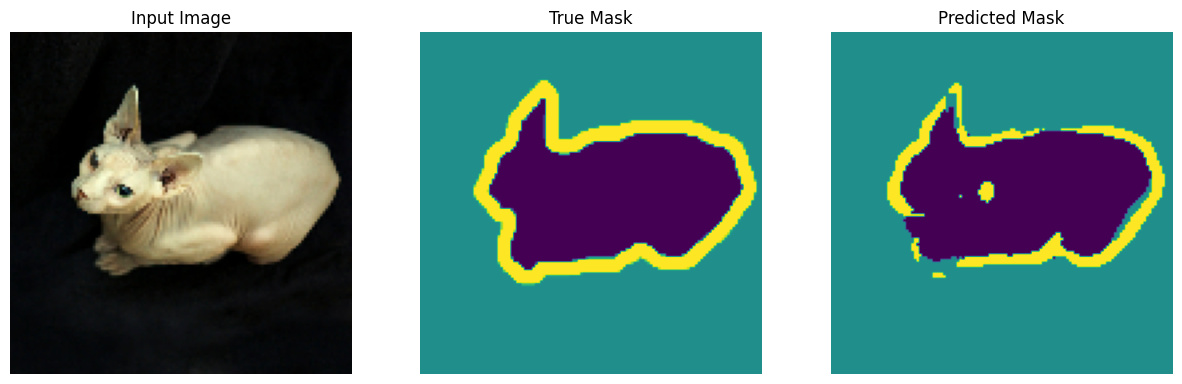


Sample Prediction after epoch 19

460/460 [==============================] - 20s 44ms/step - loss: 0.5270 - accuracy: 0.7759 - val_loss: 0.5651 - val_accuracy: 0.7587
Epoch 20/20
460/460 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.7774

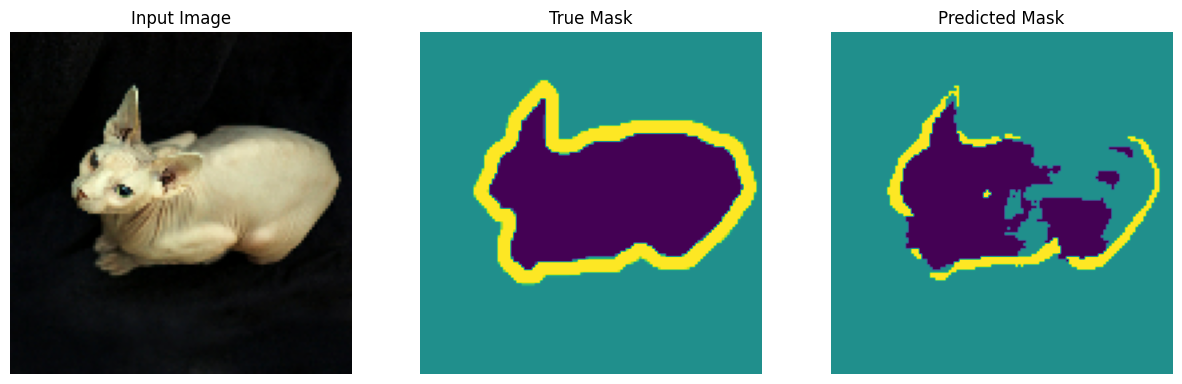


Sample Prediction after epoch 20

460/460 [==============================] - 20s 44ms/step - loss: 0.5242 - accuracy: 0.7774 - val_loss: 0.5319 - val_accuracy: 0.7792


In [9]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

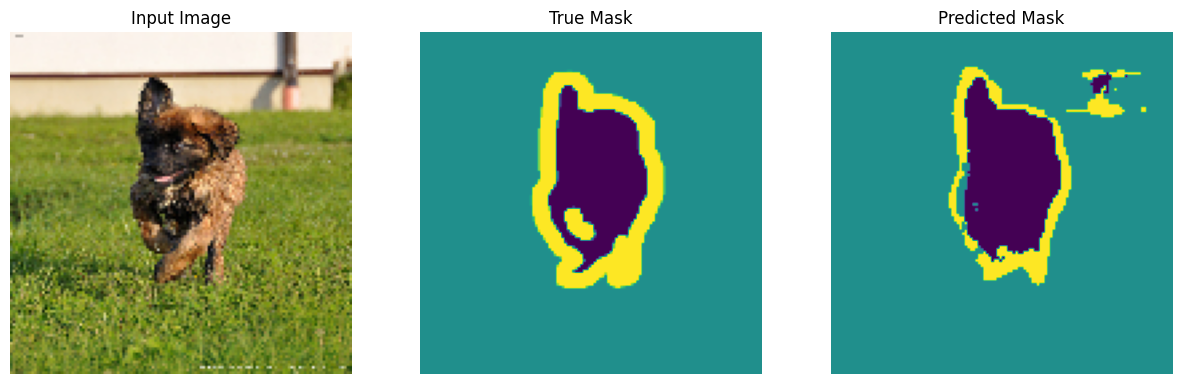

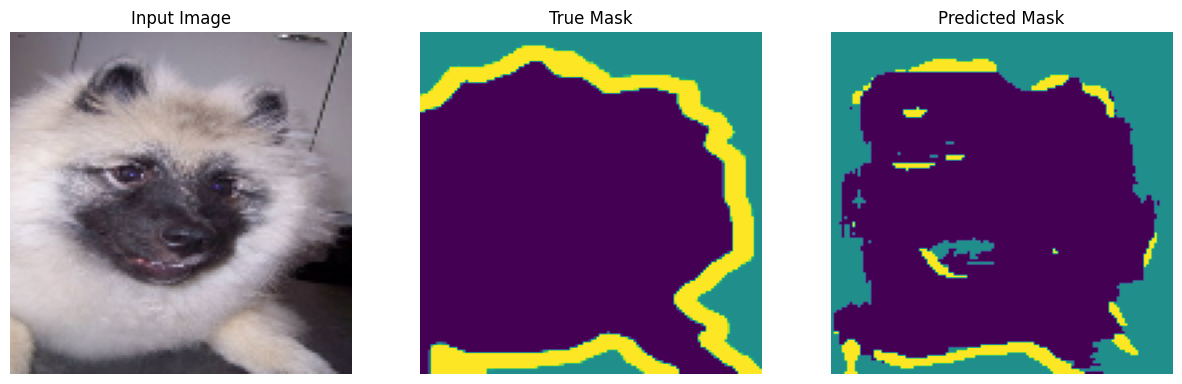

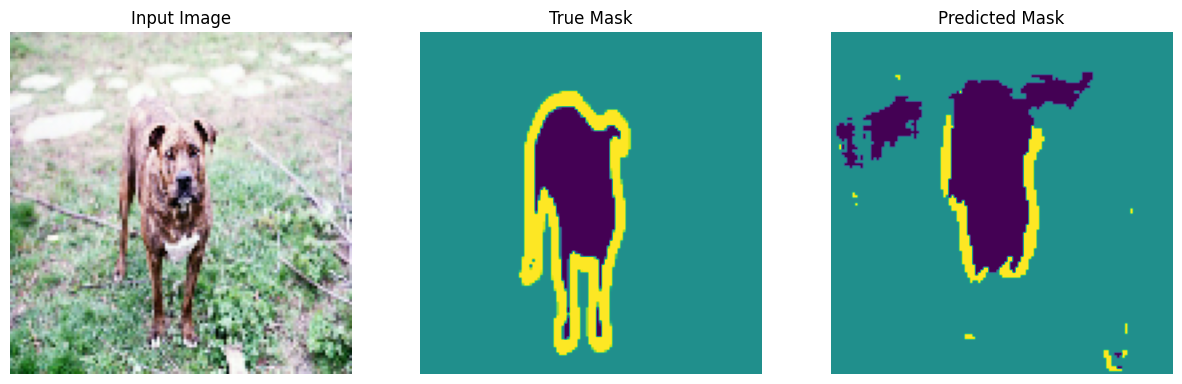

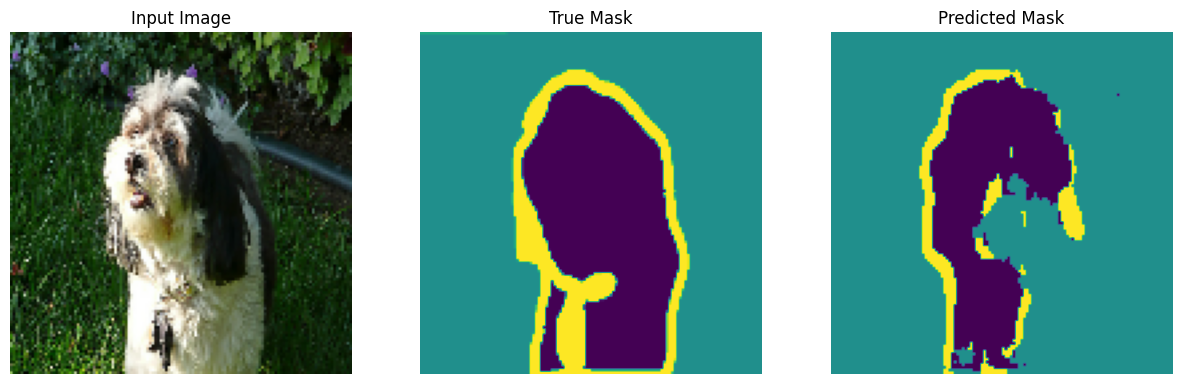

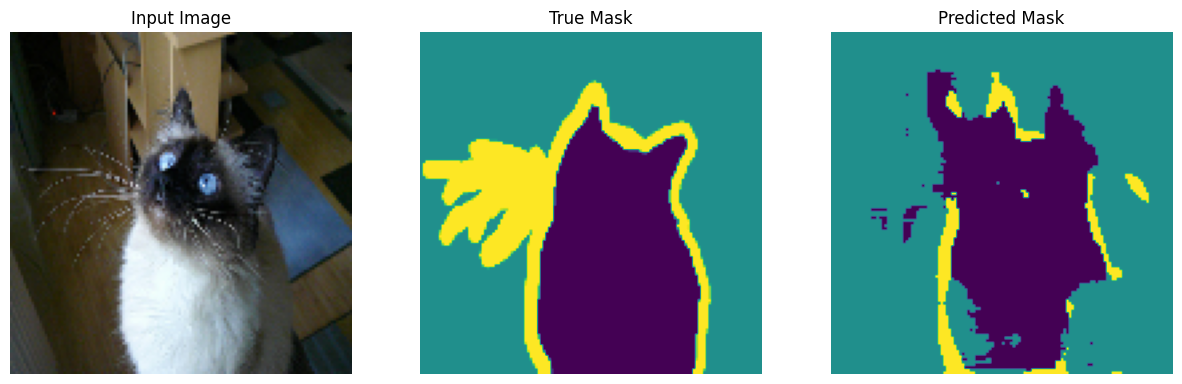

In [10]:
show_predictions(test_dataset, 5)